# Ordered MNIST (torch) [WIP]

In [ ]:
import importlib

for module in ["kooplearn", "matplotlib"]:
    try:
        importlib.import_module(module)
    except ImportError:
        if module == "kooplearn":
            module = "kooplearn[full]"
        %pip install -q {module}

In [2]:
from kooplearn.datasets import fetch_ordered_mnist
import matplotlib.pyplot as plt

In [3]:
configs = {
    "classes": 5,
    "train_samples": 1001,
    "val_ratio": 0.2,
    "test_samples": 1001,
    "rng_seed": 0,
    "batch_size": 64,
    "eval_up_to_t": 15,
    "reduced_rank": False,
    "max_epochs": 50
}

We begin by getting the Ordered MNIST dataset from `kooplearn`

In [71]:
num_digits = 5
images, labels = fetch_ordered_mnist(num_digits=num_digits)

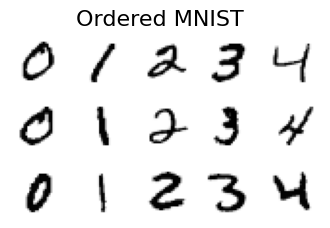

In [72]:
def plot_digits(X, title=""):
    """Small helper function to plot 100 digits."""
    fig, axs = plt.subplots(nrows=3, ncols=num_digits, figsize=(0.8*num_digits, 2.4))
    for img, ax in zip(X, axs.ravel()):
        ax.imshow(img, cmap="Greys")
        ax.axis("off")
    fig.suptitle(title, fontsize=16)
plot_digits(images, "Ordered MNIST")

Then we create train/validation/test splits

In [69]:
import numpy as np
train_ids, val_ids, test_ids = np.array_split(np.arange(3000), 3)
# train_images will be images[train_ids]

## Setting up a validation scheme
The validation of each model will be performed as follows: starting from a test image of the digit $c$, we will predict the next image by calling `model.predict`. The prediction should be an MNIST-alike image of the digit $c+1$ (modulo `configs.classes`). We will feed this prediction to a very strong MNIST classifier, and evaluate how its accuracy degrades over time. We begin by defining the _oracle_ classifier

In [70]:
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"

# Setting up the architecture
class CNNEncoder(nn.Module):
    def __init__(self, num_classes):
        super(CNNEncoder, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # Fully connected layer, output num_classes classes
        self.out = nn.Sequential(
            nn.Linear(32 * 7 * 7, num_classes),
        )
        torch.nn.init.orthogonal_(self.out[0].weight)

    def forward(self, X):
        if X.dim() == 3:
            X = X.unsqueeze(1)  # Add a channel dimension if needed
        X = self.conv1(X)
        X = self.conv2(X)
        # Flatten the output of conv2
        X = X.view(X.size(0), -1)
        output = self.out(X)
        return output

Training: 100%|██████████| 20/20 [00:08<00:00,  2.40it/s]


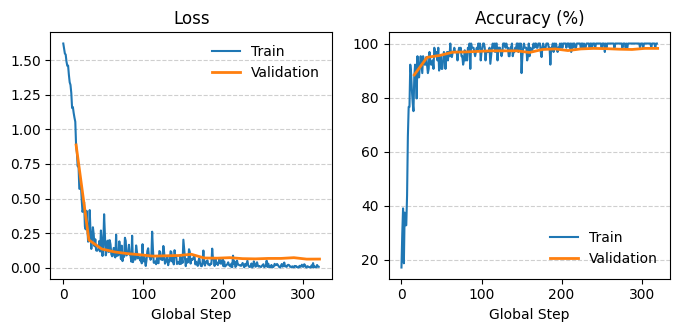

In [83]:
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm.auto import tqdm
from typing import Literal

# Prepare data
# Convert to PyTorch tensors
X_train = torch.tensor(images[train_ids], dtype=torch.float32)
labels_train = torch.tensor(labels[train_ids], dtype=torch.long)
X_val = torch.tensor(images[val_ids], dtype=torch.float32)
labels_val = torch.tensor(labels[val_ids], dtype=torch.long)
# Create data loaders
train_dataset = TensorDataset(X_train, labels_train)
train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = TensorDataset(X_val, labels_val)
val_dl = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)


torch.manual_seed(42)
oracle = CNNEncoder(num_classes=num_digits).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(oracle.parameters(), lr=1e-3)
num_epochs = 20

# metrics
metrics = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
    "train_global_step": [],
    "val_global_step": [],
}
global_step = 0

def _step(images, labels, split: Literal["train", "val"]):
    if split == "train":
        oracle.train()
    else:
        oracle.eval()
    
    images, labels = images.to(device), labels.to(device)
    
    if split =="train":
        optimizer.zero_grad()

    outputs = oracle(images)
    loss = F.cross_entropy(outputs, labels)
    if split =="train":
        loss.backward()
        optimizer.step()

    acc = (outputs.argmax(1) == labels).float().mean().item()

    # batch-level metric
    metrics[f"{split}_loss"].append(loss.item())
    metrics[f"{split}_acc"].append(acc)
    metrics[f"{split}_global_step"].append(global_step)


pbar = tqdm(range(num_epochs), desc="Training")
for epoch in pbar:
    for batch in train_dl:
        _step(*batch, "train")
        global_step += 1
    with torch.no_grad():
        for batch in val_dl:
            _step(*batch, "val")


def plot_training_history(metrics):
    _, axes = plt.subplots(1, 2, figsize=(8, 3.2))

    ax_loss = axes[0]
    ax_loss.plot(
        metrics["train_global_step"],
        metrics["train_loss"],
        label="Train",
    )
    ax_loss.plot(
        metrics["val_global_step"],
        metrics["val_loss"],
        label="Validation",
        lw=2
    )
    ax_loss.set_xlabel("Global Step")
    ax_loss.legend(frameon=False)
    ax_loss.set_title("Loss")
    ax_loss.grid(axis='y', linestyle='--', alpha=0.6)

    ax_acc = axes[1]
    # Multiply by 100 for percentage
    ax_acc.plot(
        metrics["train_global_step"],
        np.array(metrics["train_acc"]) * 100,
        label="Train",
    )
    ax_acc.plot(
        metrics["val_global_step"],
        np.array(metrics["val_acc"]) * 100,
        label="Validation",
        lw=2.0
    )
    ax_acc.set_xlabel("Global Step")
    ax_acc.legend(frameon=False)
    ax_acc.set_title("Accuracy (%)")
    ax_acc.grid(axis='y', linestyle='--', alpha=0.6)

plot_training_history(metrics)

## Model fitting

In [84]:
from kooplearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from kooplearn.utils import Flatten3DTo2DTransformer

transfer_operator_models = {}

flattener = Flatten3DTo2DTransformer()
scaler = StandardScaler()
data_pipe = Pipeline([("flattener", flattener), ("scaler", scaler)])
data_pipe.fit(images[train_ids])


def plot_rollout(model_embedder_dict, img, title=""):
    model, embedder = model_embedder_dict["model"], model_embedder_dict["embedder"]
    _, axs = plt.subplots(ncols=configs["classes"] + 1)
    for ax in axs:
        ax.imshow(img[0], cmap="Greys")
        ax.axis("off")
        try:
            _img = model.predict(embedder.transform(img))
            img = embedder.inverse_transform(_img)
        except AttributeError:
            img = model.predict(embedder.transform(img), observable=True)

### Linear Ridge Regression

In [100]:
linear_model = Ridge(n_components=num_digits, eigen_solver="dense")
linear_model.fit(data_pipe.transform(images[train_ids]))
transfer_operator_models["Linear"] = {"model": linear_model, "embedder": data_pipe}

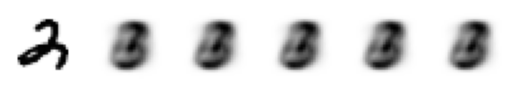

In [101]:
i = 2
initial_condition = images[test_ids][i:i + 1]
plot_rollout(transfer_operator_models["Linear"], initial_condition, "Linear")

### Classifier features (as in Sec. 6 of Kostic et al. 2022)

In [ ]:
from kooplearn.torch.utils import FeatureMapEmbedder

embedder = FeatureMapEmbedder(encoder=oracle)
images_embedded = embedder.transform(images[train_ids])
classifier_model = Ridge(n_components=configs["classes"]).fit(
    images_embedded, y=images[train_ids]
)
transfer_operator_models["Classifier_Baseline"] = {
    "model": classifier_model,
    "embedder": embedder,
}

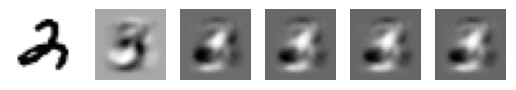

In [91]:
plot_rollout(transfer_operator_models["Classifier_Baseline"], initial_condition, "Classifier Baseline")

## NN Feature Maps

In [111]:
train_dataset = torch.from_numpy(images[train_ids]).float()
val_dataset = torch.from_numpy(images[val_ids]).float()
# Poor's man lagged dataloaders
train_dl = DataLoader(TensorDataset(train_dataset[:-1], train_dataset[1:]), batch_size=64, shuffle=True)
val_dl = DataLoader(TensorDataset(val_dataset[:-1], val_dataset[1:]), batch_size=64)

def train_feature_map(
    train_dl: DataLoader,
    val_dl: DataLoader,
    loss: torch.nn.Module,
    num_epochs: int = 100,
    learning_rate: float = 0.001,
    device: str = "cuda" if torch.cuda.is_available() else "cpu",
    seed: int = 42,
):
    torch.manual_seed(seed)
    # Initialize model, loss and optimizer
    model = CNNEncoder(num_classes=configs["classes"])
    dummy_lin = torch.nn.Linear(configs["classes"], configs["classes"], bias=False)
    model = model.to(device)
    criterion = loss()
    optimizer = optim.Adam(list(model.parameters()) + list(dummy_lin.parameters()), lr=learning_rate)

    # Training loop
    train_losses = []
    val_losses = []
    train_steps = 0
    val_steps = 0

    # Create progress bar for epochs
    pbar = tqdm(range(num_epochs), desc="Training")

    for epoch in pbar:
        # Training phase
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_dl:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            phi_X, phi_y = model(batch_X), dummy_lin(model(batch_y))
            loss = criterion(phi_X, phi_y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_steps += 1

        avg_train_loss = train_loss / len(train_dl)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_dl:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                phi_X, phi_y = model(batch_X), dummy_lin(model(batch_y))
                loss = criterion(phi_X, phi_y)

                val_loss += loss.item()
                val_steps += 1

        avg_val_loss = val_loss / len(val_dl)

        # Store metrics
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Update progress bar
        pbar.set_postfix(
            {
                "train_loss": f"{avg_train_loss:.4f}",
                "val_loss": f"{avg_val_loss:.4f}",
            }
        )

    return model, {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_steps": train_steps,
        "val_steps": val_steps,
    }


In [113]:
from kooplearn.torch.nn import VampLoss, L2ContrastiveLoss

feature_maps = {
    "VAMPNets": {
        "loss_fn": VampLoss,
        "loss_kwargs": {"schatten_norm": 2, "center_covariances": True},
    },
    "EYMNets": {"loss_fn": L2ContrastiveLoss, "loss_kwargs": {}},
}

for fname, fdict in feature_maps.items():
    print(f"Fitting {fname.replace('_', ' ')}")
    # Defining the model
    feature_map, fm_metrics = train_feature_map(
        train_dl,
        val_dl,
        fdict["loss_fn"],
        20,
        1e-3,
    )
    embedder = FeatureMapEmbedder(encoder=feature_map)
    X_train_emb = embedder.transform(X_train)
    nn_model = Ridge(n_components=configs["classes"]).fit(X_train_emb, X_train)
    transfer_operator_models[fname] = {
        "model": nn_model,
        "embedder": embedder,
    }

Fitting VAMPNets


Training: 100%|██████████| 20/20 [00:16<00:00,  1.24it/s, train_loss=-4.4775, val_loss=-3.3042]


Fitting EYMNets


Training: 100%|██████████| 20/20 [00:21<00:00,  1.07s/it, train_loss=-4.2949, val_loss=-4.3759]


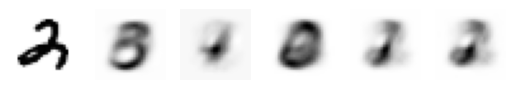

In [115]:
plot_rollout(transfer_operator_models["EYMNets"], initial_condition, "")

## Final comparison
### Model evaluation function

In [116]:
test_labels = labels[test_ids][1:]

def evaluate_model(model, embedder, test_data):
    report = {
        'accuracy': [],
        'label': [],
        'image': [],
        'times': []
    }
    test_data = embedder.transform(test_data)
    for t in range(1, configs["eval_up_to_t"] + 1):
        pred = (model.predict(test_data, n_steps=t, observable=True))
        pred_labels = oracle(torch.Tensor(pred).to(device=device)).argmax(axis=1)
        pred_labels = pred_labels.cpu().numpy()
        accuracy = (pred_labels == (test_labels + t)%configs["classes"]).mean()
        report['accuracy'].append(accuracy)
        report['image'].append(pred)
        report['label'].append(pred_labels)
        report['times'].append(t)
    return report

In [118]:
report = {}
test_data = images[test_ids][:-1]
for model_name, result in transfer_operator_models.items():
        print(f"Evaluating {model_name.replace('_', ' ')}")
        report[model_name] = evaluate_model(result["model"], result["embedder"], test_data)

Evaluating Linear


ValueError: Observable should be passed when calling fit as the y parameter.

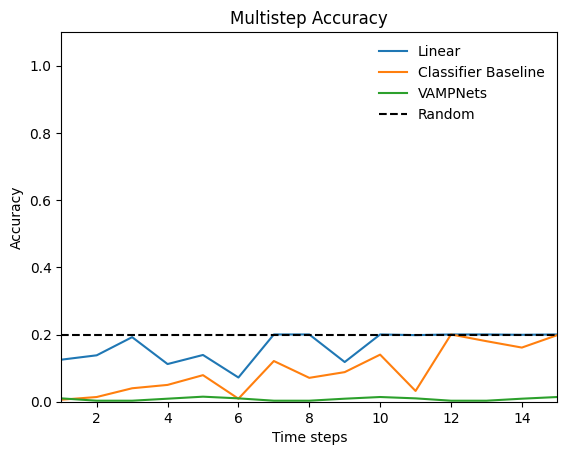

In [126]:
fig, ax = plt.subplots()
for model_name in report.keys():
    t = report[model_name]['times']
    acc = report[model_name]['accuracy']
    
    ax.plot(t, acc, label=model_name.replace('_', ' '))

ax.axhline(1/configs["classes"], color='black', linestyle='--', label='Random')

ax.legend(frameon=False, bbox_to_anchor=(1, 1))
ax.margins(x=0)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Time steps')
ax.set_ylabel('Accuracy')
ax.set_title('Multistep Accuracy')
plt.show()

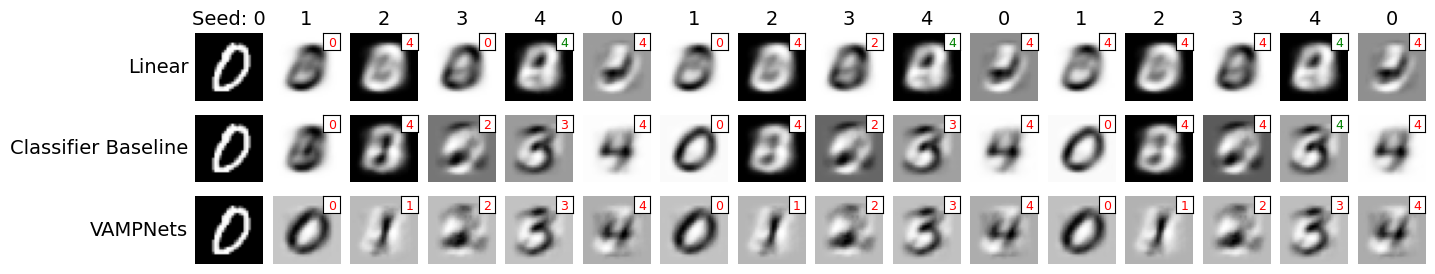

In [128]:
n_models = len(report.keys())
num_cols = configs["eval_up_to_t"] + 1
fig, axes = plt.subplots(n_models, num_cols, figsize=(num_cols, n_models), sharex=True, sharey=True)

test_seed_idx = 0
# Remove margins between columns
plt.subplots_adjust(wspace=0)

for model_idx, model_name in enumerate(report.keys()):
    ax = axes[model_idx, 0]
    ax.imshow(dataset['test'][0][test_seed_idx], cmap='gray')
    # Remove axes and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    model_eval = report[model_name]

    for t_idx in range(num_cols - 1):
        pred_label = model_eval['label'][t_idx][test_seed_idx]
        true_label = (dataset['test'][1][test_seed_idx] + model_eval['times'][t_idx])%configs["classes"]
        img = model_eval['image'][t_idx][test_seed_idx]

        # Set subplot for the current class
        ax = axes[model_idx, t_idx + 1]

        # Plot the MNIST image
        ax.imshow(img, cmap='Grays')

        # Remove axes and ticks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')

        # Add a white background for the subplot
        ax.set_facecolor('white')

        # Add an inset for the predicted label in the upper right corner
        if pred_label == true_label:
            color = 'green'
        else:
            color = 'red'
        inset_ax = ax.inset_axes([0.75, 0.75, 0.25, 0.25])
        inset_ax.set_xlim(0, 1)
        inset_ax.set_ylim(0, 1)
        inset_ax.text(0.5, 0.4, f"{pred_label}" , color=color, fontsize=9, ha='center', va='center')
        inset_ax.set_xticks([])
        inset_ax.set_yticks([])
        inset_ax.set_facecolor('white')

# Display the model names on the left of each row
for model_idx, model_name in enumerate(report.keys()):
    axes[model_idx, 0].text(-0.1, 0.5, model_name.replace('_', ' '), fontsize=14, ha='right', va='center', transform=axes[model_idx, 0].transAxes)

for class_idx in range(num_cols):
    title = (dataset['test'][1][test_seed_idx] + class_idx)%configs["classes"]
    if class_idx == 0:
        axes[0, class_idx].set_title(f"Seed: {title}", fontsize=14)
    else:
        axes[0, class_idx].set_title(f"{title}", fontsize=14)
plt.show()

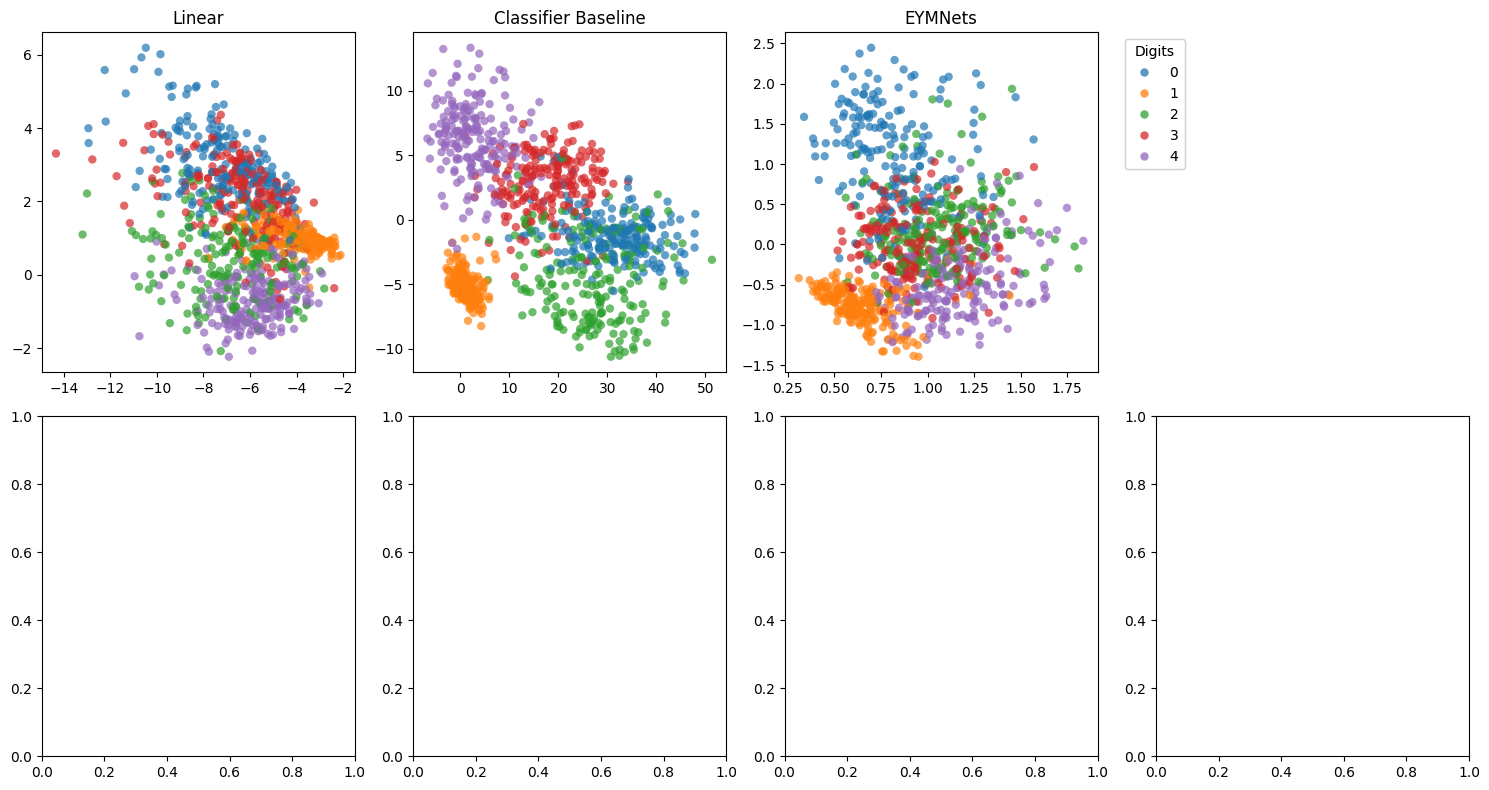

In [ ]:
from kooplearn.utils import topk

n_models = len(report.keys())
num_rows, num_cols = 2, 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))
axes = axes.flatten()
for model_idx, model_name in enumerate(report.keys()):
    ax = axes[model_idx]
    ax.title.set_text(model_name.replace('_', ' '))
    fitted_model = transfer_operator_models[model_name]
    vals, lfuncs, rfuncs = fitted_model.eig(eval_right_on=test_data, eval_left_on=test_data)
    
    unique_vals, idx_start = np.unique(np.abs(vals), return_index=True) # returns the unique values and the index of the first occurrence of a value
    
    vals, lfuncs, rfuncs = vals[idx_start], lfuncs[:, idx_start], rfuncs[:, idx_start]
    top_vals = topk(np.abs(vals), 2)
    idx_i = top_vals.indices[0]
    idx_j = top_vals.indices[1]
    
    fns = lfuncs
    fn_i = fns[:, idx_i].real
    fn_j = fns[:, idx_j].real
    
    scatter = ax.scatter(fn_i, fn_j, c=test_labels, cmap='tab10', vmax=10, alpha=0.7, linewidths=0)
    
# remove last axis and add legend
ax = axes[n_models-1]
legend = ax.legend(*scatter.legend_elements(num=4),
                    title="Digits", frameon=True, bbox_to_anchor=(1.3, 1))
ax.add_artist(legend)
fig.delaxes(axes[n_models])
    
plt.tight_layout()
plt.show()

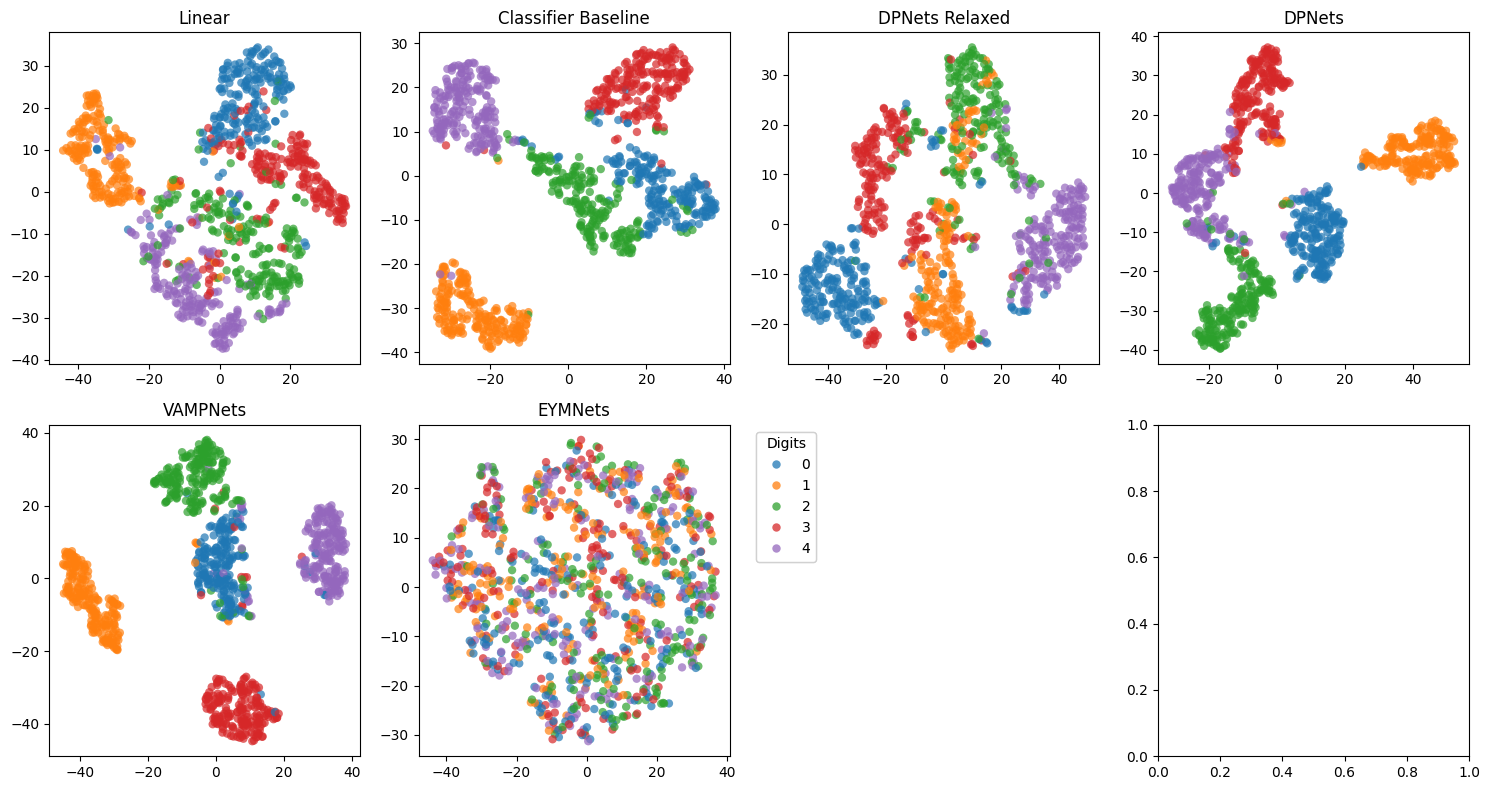

In [ ]:
from sklearn.manifold import TSNE
DimReduction = TSNE

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))
axes = axes.flatten()
for model_idx, model_name in enumerate(report.keys()):
    ax = axes[model_idx]
    ax.title.set_text(model_name.replace('_', ' '))
    fitted_model = transfer_operator_models[model_name]
    vals, lfuncs, rfuncs = fitted_model.eig(eval_right_on=test_data, eval_left_on=test_data)
    
    # returns the unique values and the index of the first occurrence of a value
    unique_vals, idx_start = np.unique(np.abs(vals), return_index=True) 
    
    vals, lfuncs, rfuncs = vals[idx_start], lfuncs[:, idx_start], rfuncs[:, idx_start]
    
    fns = lfuncs
    fns = np.column_stack([lfuncs, rfuncs])
    reduced_fns = DimReduction(n_components=2, random_state=42).fit_transform(fns.real)    
    fn_i = reduced_fns[:, 0]
    fn_j = reduced_fns[:, 1]
    
    scatter = ax.scatter(fn_i, fn_j, c=test_labels, cmap='tab10', vmax=10, alpha=0.7, linewidths=0)

# remove last axis and add legend
ax = axes[n_models-1]
legend = ax.legend(*scatter.legend_elements(num=4),
                    title="Digits", frameon=True, bbox_to_anchor=(1.3, 1))
ax.add_artist(legend)
fig.delaxes(axes[n_models])
    
plt.tight_layout()
plt.show()